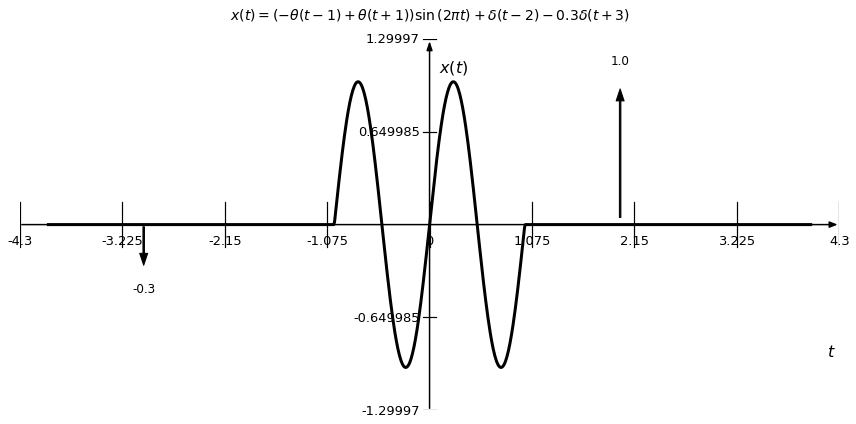

In [21]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from sympy.parsing.sympy_parser import parse_expr, standard_transformations, implicit_multiplication_application

class SignalPlotter:
    def __init__(self, expr_str, var='t', time_range=(-5, 5), num_points=1000, figsize=(12, 2.5)):
        self.var_name = var
        self.t = sp.symbols(var)
        self.time_range = time_range
        self.num_points = num_points
        self.figsize = figsize

        # Diccionario de funciones conocidas
        self.local_dict = {
            'u': sp.Heaviside,
            'delta': sp.DiracDelta,
            'DiracDelta': sp.DiracDelta,
            'Heaviside': sp.Heaviside,
            'pi': sp.pi,
            var: self.t,
            'sin': sp.sin,
            'cos': sp.cos,
            'exp': sp.exp
        }

        # Transformaciones para permitir multiplicación implícita
        transformations = standard_transformations + (implicit_multiplication_application,)

        # Parsear la expresión
        self.expr = parse_expr(expr_str, local_dict=self.local_dict, transformations=transformations)

    def _extract_impulses(self):
        impulse_locs = []
        impulse_amps = []
        expr_terms = self.expr.as_ordered_terms()

        for term in expr_terms:
            deltas = term.atoms(sp.DiracDelta)
            if deltas:
                for d in deltas:
                    arg = d.args[0]
                    roots = sp.solve(arg, self.t)
                    amp = term.coeff(d)
                    if roots:
                        impulse_locs.append(float(roots[0]))
                        impulse_amps.append(float(amp))
        return impulse_locs, impulse_amps

    def _remove_dirac_terms(self):
        return self.expr.replace(lambda expr: expr.has(sp.DiracDelta), lambda _: 0)

    def plot2(self):
        fig, ax = plt.subplots(figsize=(8, 4))
        t_vals = np.linspace(self.time_range[0], self.time_range[1], self.num_points)

        # Extraer impulsos y eliminar deltas para graficar parte continua
        impulse_locs, impulse_amps = self._extract_impulses()
        expr_cont = self._remove_dirac_terms()

        # Dibujar parte continua
        func = sp.lambdify(self.t, expr_cont, modules=["numpy"])
        try:
            y_vals = func(t_vals)
            ax.plot(t_vals, y_vals, label='Parte continua', color='blue')
        except Exception:
            pass  # No hay parte continua o error de evaluación

        # Dibujar deltas
        for t0, amp in zip(impulse_locs, impulse_amps):
            ax.annotate('', xy=(t0, amp), xytext=(t0, 0),
                        arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))
            ax.text(t0, amp + 0.1*np.sign(amp), f'{amp}', ha='center',
                    va='bottom' if amp > 0 else 'top', fontsize=10)

        # Estilo Oppenheim
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.set_xlabel(self.var_name)
        ax.set_ylabel('x(' + self.var_name + ')')
        ax.set_xlim(self.time_range)
        ax.set_title(f'$x({self.var_name}) = {sp.latex(self.expr)}$')

        plt.tight_layout()
        plt.show()

    def plot(self):
        fig, ax = plt.subplots(figsize=self.figsize)
        t_vals = np.linspace(self.time_range[0], self.time_range[1], self.num_points)

        # Extraer impulsos y eliminar deltas para graficar parte continua
        impulse_locs, impulse_amps = self._extract_impulses()
        expr_cont = self._remove_dirac_terms()

        # Evaluar parte continua
        func = sp.lambdify(self.t, expr_cont, modules=["numpy"])
        try:
            y_vals = func(t_vals)
            ax.plot(t_vals, y_vals, color='black', linewidth=3, zorder=5)
        except Exception:
            pass

        # Dibujar deltas
        for t0, amp in zip(impulse_locs, impulse_amps):
            ax.annotate('', xy=(t0, amp), xytext=(t0, 0),
                        arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))
            ax.text(t0, amp + 0.1*np.sign(amp), f'{amp}', ha='center',
                    va='bottom' if amp > 0 else 'top', fontsize=12)

        # Ocultar todos los spines
        for spine in ax.spines.values():
            spine.set_color('none')

        # Márgenes adicionales para ejes visuales más largos
        x_margin = 0.3
        y_margin = 0.3
        x0, x1 = self.time_range
        y_vals_f = func(t_vals) if expr_cont != 0 else np.zeros_like(t_vals)
        y0 = min(0, np.min(y_vals_f)) - y_margin
        y1 = max(0, np.max(y_vals_f)) + y_margin
        ax.set_xlim(x0 - x_margin, x1 + x_margin)
        ax.set_ylim(y0, y1)

        # Flechas (ejes coordenados)
        ax.annotate('', 
                    xy=(ax.get_xlim()[1], 0), xytext=(ax.get_xlim()[0], 0),
                    arrowprops=dict(arrowstyle='-|>', linewidth=1.5, color='black',
                                    mutation_scale=16, mutation_aspect=0.8, fc='black'))

        ax.annotate('', 
                    xy=(0, ax.get_ylim()[1]), xytext=(0, ax.get_ylim()[0]),
                    arrowprops=dict(arrowstyle='-|>', linewidth=1.5, color='black',
                                    mutation_scale=12, mutation_aspect=1.5, fc='black'))

        # Desactivar ticks automáticos
        ax.set_xticks([])
        ax.set_yticks([])

        # Dibujar ticks manuales sobre los ejes coordenados
        tick_length = 0.12 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # altura en unidades del eje y
        tick_width = 0.015 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # anchura en unidades del eje x

        # Ticks del eje x sobre y=0
        xticks = np.linspace(*ax.get_xlim(), 9)
        for x in xticks:
            ax.plot([x, x], [0 - tick_length/2, 0 + tick_length/2], color='black', linewidth=1.2, zorder=10)

        # Ticks del eje y sobre x=0
        yticks = np.linspace(*ax.get_ylim(), 5)
        for y in yticks:
            if abs(y) < 1e-8:  # evitar solapamiento con eje
                continue
            ax.plot([0 - tick_width/2, 0 + tick_width/2], [y, y], color='black', linewidth=1.2, zorder=10)

        for x in xticks:
            ax.annotate(f'{x:g}', xy=(x, 0), xycoords='data',
                        textcoords='offset points', xytext=(0, -10),
                        ha='center', va='top', fontsize=13)

        for y in yticks:
            if abs(y) < 1e-8:
                continue
            ax.annotate(f'{y:g}', xy=(0, y), xycoords='data',
                        textcoords='offset points', xytext=(-10, 0),
                        ha='right', va='center', fontsize=13)

        # Etiquetas de ejes
        ax.set_xlabel(f'${self.var_name}$', fontsize=16, labelpad=-40)
        ax.xaxis.set_label_coords(0.99, 0.18)

        ax.set_ylabel(rf'$x({self.var_name})$', rotation=0, fontsize=16)
        ax.yaxis.set_label_coords(0.53, 0.9)

        # Título en LaTeX
        ax.set_title(f'$x({self.var_name}) = {sp.latex(self.expr)}$', fontsize=14, pad=20)

        # Sin grid
        ax.grid(False)

        plt.tight_layout()
        plt.show()




plotter = SignalPlotter(
    "sin(2*pi*t)*(u(t+1)-u(t-1)) + delta(t-2) - 0.3*delta(t+3)",
    time_range=(-4, 4),
    figsize=(12, 6)
)
plotter.plot()


In [31]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from sympy.parsing.sympy_parser import parse_expr, standard_transformations, implicit_multiplication_application

class SignalPlotter:
    def __init__(self, expr_str, var='t', time_range=(-5, 5), num_points=1000, figsize=(10, 3)):
        self.var_name = var
        self.t = sp.symbols(var)
        self.time_range = time_range
        self.num_points = num_points
        self.figsize = figsize

        self.local_dict = {
            'u': sp.Heaviside,
            'delta': sp.DiracDelta,
            'DiracDelta': sp.DiracDelta,
            'Heaviside': sp.Heaviside,
            'pi': sp.pi,
            var: self.t,
            'sin': sp.sin,
            'cos': sp.cos,
            'exp': sp.exp
        }

        transformations = standard_transformations + (implicit_multiplication_application,)
        self.expr = parse_expr(expr_str, local_dict=self.local_dict, transformations=transformations)

    def _extract_impulses(self):
        impulse_locs = []
        impulse_amps = []
        expr_terms = self.expr.as_ordered_terms()

        for term in expr_terms:
            deltas = term.atoms(sp.DiracDelta)
            for d in deltas:
                arg = d.args[0]
                roots = sp.solve(arg, self.t)
                amp = term.coeff(d)
                if roots:
                    impulse_locs.append(float(roots[0]))
                    impulse_amps.append(float(amp))
        return impulse_locs, impulse_amps

    def _remove_dirac_terms(self):
        return self.expr.replace(lambda expr: expr.has(sp.DiracDelta), lambda _: 0)

    def plot(self):
        fig, ax = plt.subplots(figsize=self.figsize)
        t_vals = np.linspace(self.time_range[0], self.time_range[1], self.num_points)

        impulse_locs, impulse_amps = self._extract_impulses()
        expr_cont = self._remove_dirac_terms()
        func = sp.lambdify(self.t, expr_cont, modules=["numpy"])

        # Estimar límites verticales
        try:
            y_vals = func(t_vals)
            ax.plot(t_vals, y_vals, color='black', linewidth=2.5, zorder=5)
            y_min, y_max = np.min(y_vals), np.max(y_vals)
        except Exception:
            y_vals = np.zeros_like(t_vals)
            y_min, y_max = -1, 1

        for t0, amp in zip(impulse_locs, impulse_amps):
            ax.annotate('', xy=(t0, amp), xytext=(t0, 0),
                        arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))
            ax.text(t0, amp + 0.1*np.sign(amp), f'{amp:g}', ha='center',
                    va='bottom' if amp > 0 else 'top', fontsize=11)

        # Ocultar todos los spines
        for spine in ax.spines.values():
            spine.set_color('none')

        # Márgenes visuales
        x_margin = 0.3
        y_margin = 0.2 * (y_max - y_min + 1)
        ax.set_xlim(self.time_range[0] - x_margin, self.time_range[1] + x_margin)
        ax.set_ylim(y_min - 0.05, y_max + y_margin)

        # Flechas ejes
        ax.annotate('', 
                    xy=(ax.get_xlim()[1], 0), xytext=(ax.get_xlim()[0], 0),
                    arrowprops=dict(arrowstyle='-|>', linewidth=1.5, color='black',
                                    mutation_scale=16, mutation_aspect=0.8, fc='black'))

        ax.annotate('', 
                    xy=(0, ax.get_ylim()[1]), xytext=(0, ax.get_ylim()[0]),
                    arrowprops=dict(arrowstyle='-|>', linewidth=1.5, color='black',
                                    mutation_scale=10, mutation_aspect=2, fc='black'))

        # Ticks y etiquetas sobre los ejes coordenados
        ax.set_xticks([])
        ax.set_yticks([])

        # Transformaciones combinadas
        trans_x = blended_transform_factory(ax.transData, ax.transAxes)
        trans_y = blended_transform_factory(ax.transAxes, ax.transData)
        tick_size = 0.015  # constante visual

        # Ticks x
        xticks = np.linspace(*self.time_range, 5)
        for x in xticks:
            ax.plot([x, x], [0.5 - tick_size, 0.5 + tick_size], transform=trans_x,
                    color='black', linewidth=1.2, clip_on=False)
            ax.annotate(f'{x:g}', xy=(x, 0), xycoords='data',
                        textcoords='offset points', xytext=(0, -10),
                        ha='center', va='top', fontsize=12)

        # Ticks y
        yticks = np.linspace(round(y_min), round(y_max), 3)
        for y in yticks:
            if abs(y) < 1e-8:
                continue
            ax.plot([0.5 - tick_size, 0.5 + tick_size], [y, y], transform=trans_y,
                    color='black', linewidth=1.2, clip_on=False)
            ax.annotate(f'{y:g}', xy=(0, y), xycoords='data',
                        textcoords='offset points', xytext=(-10, 0),
                        ha='right', va='center', fontsize=12)

        # Etiquetas de ejes
        ax.set_xlabel(f'${self.var_name}$', fontsize=16, labelpad=-40)
        ax.xaxis.set_label_coords(0.98, 0.18)
        ax.set_ylabel(rf'$x({self.var_name})$', rotation=0, fontsize=16)
        ax.yaxis.set_label_coords(0.5, 0.95)

        # Sin grid ni marco
        ax.grid(False)

        plt.tight_layout()
        plt.show()


In [104]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from sympy.parsing.sympy_parser import parse_expr, standard_transformations, implicit_multiplication_application

class SignalPlotter:
    def __init__(self, expr_str, var='t', time_range=(-5, 5), num_points=1000, figsize=(10, 3)):
        self.var_name = var
        self.t = sp.symbols(var)
        self.time_range = time_range
        self.num_points = num_points
        self.figsize = figsize

        self.local_dict = {
            'u': sp.Heaviside,
            'delta': sp.DiracDelta,
            'DiracDelta': sp.DiracDelta,
            'Heaviside': sp.Heaviside,
            'pi': sp.pi,
            var: self.t,
            'sin': sp.sin,
            'cos': sp.cos,
            'exp': sp.exp
        }

        transformations = standard_transformations + (implicit_multiplication_application,)
        self.expr = parse_expr(expr_str, local_dict=self.local_dict, transformations=transformations)

    def _extract_impulses(self):
        impulse_locs = []
        impulse_amps = []
        # Obtener términos que contienen DiracDelta
        expr_terms = self.expr.as_ordered_terms()
        for term in expr_terms:
            deltas = term.atoms(sp.DiracDelta)
            for d in deltas:
                arg = d.args[0]
                roots = sp.solve(arg, self.t)
                # Coeficiente exacto para este delta
                # Multiplicamos por la derivada en la raíz si es posible para amplitud física correcta
                if roots:
                    root_val = roots[0]
                    # Obtener coeficiente multiplicando por derivada para delta escalada (DiracDelta(ax) = 1/|a| DiracDelta(x))
                    deriv = sp.diff(arg, self.t).subs(self.t, root_val)
                    amp = term.coeff(d) / abs(float(deriv)) if deriv != 0 else term.coeff(d)
                    impulse_locs.append(float(root_val))
                    impulse_amps.append(float(amp))
        return impulse_locs, impulse_amps

    def _remove_dirac_terms(self):
        return self.expr.replace(lambda expr: expr.has(sp.DiracDelta), lambda _: 0)

    def plot(self):
        fig, ax = plt.subplots(figsize=self.figsize)
        t_vals = np.linspace(self.time_range[0], self.time_range[1], self.num_points)

        impulse_locs, impulse_amps = self._extract_impulses()
        expr_cont = self._remove_dirac_terms()
        func = sp.lambdify(self.t, expr_cont, modules=["numpy"])

        try:
            y_vals = func(t_vals)
            y_vals = np.array(y_vals, dtype=np.float64)
            y_vals = y_vals[np.isfinite(y_vals)]
            y_min, y_max = np.min(y_vals), np.max(y_vals)
            if abs(y_max - y_min) < 1e-2:
                y_min -= 1
                y_max += 1
        except Exception:
            y_vals = np.zeros_like(t_vals)
            y_min, y_max = -1, 1

        y_plot = func(t_vals)
        ax.plot(t_vals, y_plot, color='black', linewidth=2.5, zorder=5)

        for t0, amp in zip(impulse_locs, impulse_amps):
            ax.annotate('', xy=(t0, amp), xytext=(t0, 0),
                        arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))
            ax.text(t0, amp + 0.1*np.sign(amp), f'{amp:g}', ha='center',
                    va='bottom' if amp > 0 else 'top', fontsize=11)

        for spine in ax.spines.values():
            spine.set_color('none')

        x_margin = 0.3
        y_margin = 0.25 * (y_max - y_min)
        ax.set_xlim(self.time_range[0] - x_margin, self.time_range[1] + x_margin)
        ax.set_ylim(y_min - y_margin, y_max + y_margin)

        # Ejes con flechas
        ax.annotate('',
                    xy=(ax.get_xlim()[1], 0), xytext=(ax.get_xlim()[0], 0),
                    arrowprops=dict(arrowstyle='-|>', linewidth=1.5, color='black',
                                    mutation_scale=16, mutation_aspect=0.8, fc='black'))

        ax.annotate('',
                    xy=(0, ax.get_ylim()[1]), xytext=(0, ax.get_ylim()[0]),
                    arrowprops=dict(arrowstyle='-|>', linewidth=1.5, color='black',
                                    mutation_scale=12, mutation_aspect=2, fc='black'))

        ax.set_xticks([])
        ax.set_yticks([])

        tick_px = 10  # tamaño deseado en píxeles

        # Conversión correcta de píxeles a unidades data (X)
        def px_to_data_x(px):
            # Transformamos un punto arbitrario en data y otro desplazado en px en pantalla,
            # y calculamos la diferencia en data:
            p_data = np.array([0, 0])
            p_disp = ax.transData.transform(p_data)
            p_disp_px = p_disp + np.array([px, 0])
            p_data_px = ax.transData.inverted().transform(p_disp_px)
            return p_data_px[0] - p_data[0]

        # Conversión correcta de píxeles a unidades data (Y)
        def px_to_data_y(px):
            p_data = np.array([0, 0])
            p_disp = ax.transData.transform(p_data)
            p_disp_px = p_disp + np.array([0, px])
            p_data_px = ax.transData.inverted().transform(p_disp_px)
            return p_data_px[1] - p_data[1]

        # Conversión correcta de píxeles a unidades axes (X)
        def px_to_axes_x(px):
            p_axes = np.array([0, 0])
            p_disp = ax.transAxes.transform(p_axes)
            p_disp_px = p_disp + np.array([px, 0])
            p_axes_px = ax.transAxes.inverted().transform(p_disp_px)
            return p_axes_px[0] - p_axes[0]

        # Conversión correcta de píxeles a unidades axes (Y)
        def px_to_axes_y(px):
            p_axes = np.array([0, 0])
            p_disp = ax.transAxes.transform(p_axes)
            p_disp_px = p_disp + np.array([0, px])
            p_axes_px = ax.transAxes.inverted().transform(p_disp_px)
            return p_axes_px[1] - p_axes[1]

        # Dibujo ticks X
        xticks = np.linspace(*self.time_range, 5)
        for x in xticks:
            delta_y = px_to_axes_y(tick_px) / 2
            ax.plot([x, x], [0.5 - delta_y, 0.5 + delta_y],
                    transform=blended_transform_factory(ax.transData, ax.transAxes),
                    color='black', linewidth=1.2, clip_on=False)
            ax.annotate(f'{x:g}', xy=(x, 0), xycoords='data',
                        textcoords='offset points', xytext=(0, -12),
                        ha='center', va='top', fontsize=12)

        # Dibujo ticks Y
        yticks_raw = np.linspace(np.floor(y_min), np.ceil(y_max), 3)
        yticks = [y for y in yticks_raw if abs(y) > 1e-6]
        for y in yticks:
            delta_x = px_to_axes_x(tick_px) / 2
            ax.plot([0.5 - delta_x, 0.5 + delta_x], [y, y],
                    transform=blended_transform_factory(ax.transAxes, ax.transData),
                    color='black', linewidth=1.2, clip_on=False)
            ax.annotate(f'{y:g}', xy=(0, y), xycoords='data',
                        textcoords='offset points', xytext=(-12, 0),
                        ha='right', va='center', fontsize=12)

        # Etiquetas de ejes (igual que antes)
        ax.set_xlabel(f'${self.var_name}$', fontsize=16, labelpad=10)
        ax.xaxis.set_label_coords(0.98, 0.85)
        ax.set_ylabel(rf'$x({self.var_name})$', rotation=0, fontsize=16)
        ax.yaxis.set_label_coords(0.58, 0.95)
        ax.yaxis.get_label().set_horizontalalignment('left')

        ax.grid(False)
        plt.tight_layout()
        plt.show()



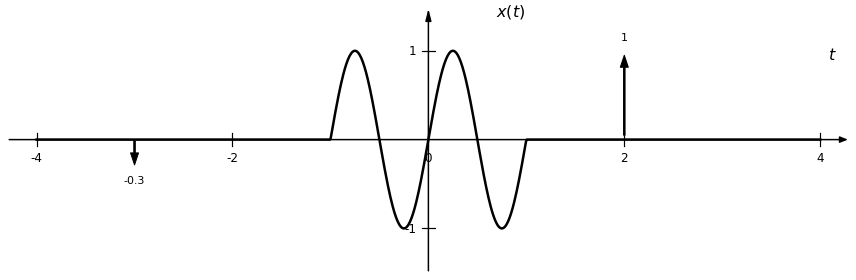

In [105]:
plotter = SignalPlotter("sin(2*pi*t)*(u(t+1)-u(t-1)) + delta(t-2) - 0.3*delta(t+3)", 
                        time_range=(-4, 4), figsize=(12, 4))
plotter.plot()

In [149]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from sympy.parsing.sympy_parser import parse_expr, standard_transformations, implicit_multiplication_application

class SignalPlotter:
    def __init__(self, expr_str, var='t', time_range=(-5, 5), num_points=1000,
                 figsize=(10, 3), tick_size_px=10, xticks=None, yticks=None):
        """
        xticks, yticks: 
            None => ticks automáticos (5 para x, 3 para y)
            lista de posiciones (numéricas)
        tick_size_px: tamaño visual del tick en píxeles (igual para ambos ejes)
        """
        self.var_name = var
        self.t = sp.symbols(var)
        self.time_range = time_range
        self.num_points = num_points
        self.figsize = figsize
        self.tick_size_px = tick_size_px
        self.custom_xticks = xticks
        self.custom_yticks = yticks

        self.local_dict = {
            'u': sp.Heaviside,
            'delta': sp.DiracDelta,
            'DiracDelta': sp.DiracDelta,
            'Heaviside': sp.Heaviside,
            'pi': sp.pi,
            var: self.t,
            'sin': sp.sin,
            'cos': sp.cos,
            'exp': sp.exp
        }

        transformations = standard_transformations + (implicit_multiplication_application,)
        self.expr = parse_expr(expr_str, local_dict=self.local_dict, transformations=transformations)

    def _extract_impulses(self):
        impulse_locs = []
        impulse_amps = []
        expr_terms = self.expr.as_ordered_terms()

        for term in expr_terms:
            deltas = term.atoms(sp.DiracDelta)
            for d in deltas:
                arg = d.args[0]
                roots = sp.solve(arg, self.t)
                amp = term.coeff(d)
                if roots:
                    impulse_locs.append(float(roots[0]))
                    impulse_amps.append(float(amp))
        return impulse_locs, impulse_amps

    def _remove_dirac_terms(self):
        return self.expr.replace(lambda expr: expr.has(sp.DiracDelta), lambda _: 0)

    def plot(self):
        fig, ax = plt.subplots(figsize=self.figsize)
        t_vals = np.linspace(self.time_range[0], self.time_range[1], self.num_points)

        impulse_locs, impulse_amps = self._extract_impulses()
        expr_cont = self._remove_dirac_terms()
        func = sp.lambdify(self.t, expr_cont, modules=["numpy"])

        try:
            y_vals = func(t_vals)
            y_vals = np.array(y_vals, dtype=np.float64)
            y_vals = y_vals[np.isfinite(y_vals)]
            y_min, y_max = np.min(y_vals), np.max(y_vals)
            if abs(y_max - y_min) < 1e-2:
                y_min -= 1
                y_max += 1
        except Exception:
            y_vals = np.zeros_like(t_vals)
            y_min, y_max = -1, 1

        y_plot = func(t_vals)
        ax.plot(t_vals, y_plot, color='black', linewidth=2.5, zorder=5)

        # Impulsos
        for t0, amp in zip(impulse_locs, impulse_amps):
            ax.annotate('', xy=(t0, amp), xytext=(t0, 0),
                        arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))
            ax.text(t0, amp + 0.1*np.sign(amp), f'{amp:g}', ha='center',
                    va='bottom' if amp > 0 else 'top', fontsize=11)

        # Ocultar spines
        for spine in ax.spines.values():
            spine.set_color('none')

        x_margin = 0.3
        y_margin = 0.25 * (y_max - y_min)
        ax.set_xlim(self.time_range[0] - x_margin, self.time_range[1] + x_margin)
        ax.set_ylim(y_min - y_margin, y_max + y_margin)

        # Ejes con flechas
        ax.annotate('',
                    xy=(ax.get_xlim()[1], 0), xytext=(ax.get_xlim()[0], 0),
                    arrowprops=dict(arrowstyle='-|>', linewidth=1.5, color='black',
                                    mutation_scale=16, mutation_aspect=0.8, fc='black'))

        ax.annotate('',
                    xy=(0, ax.get_ylim()[1]), xytext=(0, ax.get_ylim()[0]),
                    arrowprops=dict(arrowstyle='-|>', linewidth=1.5, color='black',
                                    mutation_scale=12, mutation_aspect=2, fc='black'))

        # No ticks nativos de matplotlib
        ax.set_xticks([])
        ax.set_yticks([])

        # Funciones de conversión píxeles a unidades de ejes y data
        def px_to_data_x(px):
            p_data = np.array([0, 0])
            p_disp = ax.transData.transform(p_data)
            p_disp_px = p_disp + np.array([px, 0])
            p_data_px = ax.transData.inverted().transform(p_disp_px)
            return p_data_px[0] - p_data[0]

        def px_to_data_y(px):
            p_data = np.array([0, 0])
            p_disp = ax.transData.transform(p_data)
            p_disp_px = p_disp + np.array([0, px])
            p_data_px = ax.transData.inverted().transform(p_disp_px)
            return p_data_px[1] - p_data[1]

        def px_to_axes_x(px):
            p_axes = np.array([0, 0])
            p_disp = ax.transAxes.transform(p_axes)
            p_disp_px = p_disp + np.array([px, 0])
            p_axes_px = ax.transAxes.inverted().transform(p_disp_px)
            return p_axes_px[0] - p_axes[0]

        def px_to_axes_y(px):
            p_axes = np.array([0, 0])
            p_disp = ax.transAxes.transform(p_axes)
            p_disp_px = p_disp + np.array([0, px])
            p_axes_px = ax.transAxes.inverted().transform(p_disp_px)
            return p_axes_px[1] - p_axes[1]

        tick_px = self.tick_size_px

        # Definir xticks
        if self.custom_xticks is None:
            xticks = np.linspace(*self.time_range, 5)
        else:
            xticks = np.array(self.custom_xticks)

        # Definir yticks (descartando 0 para evitar etiqueta sobre eje)
        if self.custom_yticks is None:
            yticks_raw = np.linspace(np.floor(y_min), np.ceil(y_max), 3)
            yticks = [y for y in yticks_raw if abs(y) > 1e-6]
        else:
            yticks = [y for y in self.custom_yticks if abs(y) > 1e-6]

        # Dibujar ticks X (líneas y etiquetas)
        delta_y = px_to_axes_y(tick_px) / 2
        for x in xticks:
            # línea vertical del tick (en coords data en x, coords axes en y)
            ax.plot([x, x], [0.5 - delta_y, 0.5 + delta_y],
                    transform=blended_transform_factory(ax.transData, ax.transAxes),
                    color='black', linewidth=1.2, clip_on=False)
            ax.annotate(f'{x:g}', xy=(x, 0), xycoords='data',
                        textcoords='offset points', xytext=(0, -12),
                        ha='center', va='top', fontsize=12)

        # Dibujar ticks Y (líneas y etiquetas)
        delta_x = px_to_axes_x(tick_px) / 2
        for y in yticks:
            # línea horizontal del tick (en coords axes en x, coords data en y)
            ax.plot([0.5 - delta_x, 0.5 + delta_x], [y, y],
                    transform=blended_transform_factory(ax.transAxes, ax.transData),
                    color='black', linewidth=1.2, clip_on=False)
            ax.annotate(f'{y:g}', xy=(0, y), xycoords='data',
                        textcoords='offset points', xytext=(-12, 0),
                        ha='right', va='center', fontsize=12)

        # Etiquetas de ejes con ajuste para que no queden tapadas por flechas
        ax.set_xlabel(f'${self.var_name}$', fontsize=16, labelpad=10)
        ax.xaxis.set_label_coords(0.98, 0.53)
        ax.xaxis.get_label().set_horizontalalignment('left')
        ax.xaxis.get_label().set_verticalalignment('bottom')
        ax.set_ylabel(rf'$\ \ x({self.var_name})$', rotation=0, fontsize=16)
        ax.yaxis.set_label_coords(0.5, 0.95)
        ax.yaxis.get_label().set_horizontalalignment('left')
        ax.yaxis.get_label().set_verticalalignment('center')

        ax.grid(False)
        plt.tight_layout()
        plt.show()


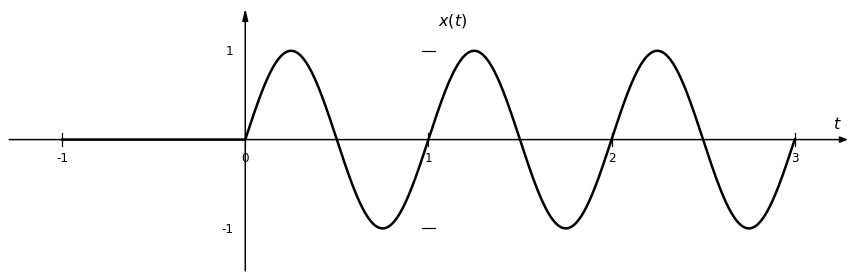

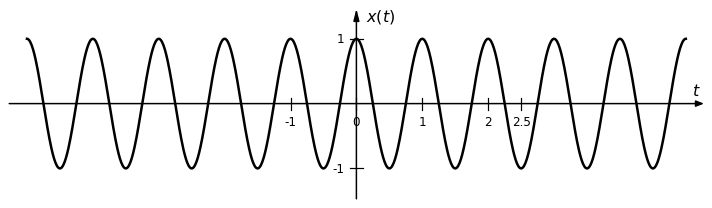

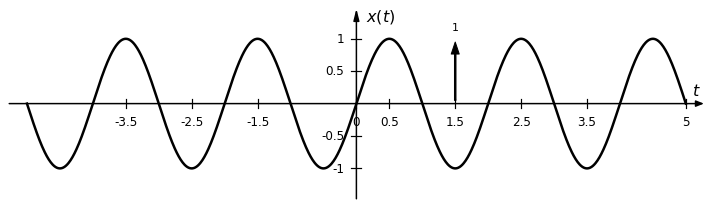

In [159]:
# Automático
sp1 = SignalPlotter('sin(2*pi*t)*u(t)', time_range=(-1, 3), figsize=(12, 4))
sp1.plot()

# Personalizado ticks x
sp2 = SignalPlotter('cos(2*pi*t)', xticks=[-1, 0, 1, 2, 2.5])
sp2.plot()

# Personalizado ticks y
sp3 = SignalPlotter('sin(pi*t) + delta(t-3/2)', xticks=[-3.5, -2.5, -1.5, -0,5, 0.5, 1.5, 2.5, 3.5], yticks=[-1, -0.5, 0.5, 1], tick_size_px=8)
sp3.plot()
